# Baseline решение по дедупликации


In [2]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [3]:
with open('data_source/sample.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print(len(data))
print(data[0].keys())
print(json.dumps(data[0], indent=2, ensure_ascii=False))

6918
dict_keys(['source', 'text', 'publication_date'])
{
  "source": "lenta.ru",
  "text": "В 1930-е годы Советский Союз охватила лихорадка — в десятилетие бурной индустриализации повсюду гремели сообщения о новых трудовых подвигах простого народа ради построения коммунизма и светлого будущего. Первым из них стал шахтер из Донбасса Алексей Стаханов. 85 лет назад он установил рекорд по добыче угля за смену и на следующее утро проснулся знаменитым на весь мир. Его одаривали квартирами и машинами, возили по Союзу, он стал любимцем Сталина, однако в итоге не выдержал славы и спился. Фамилия Стаханова, которая дала название движению трудовиков, превратилась в нарицательную и продолжила существовать отдельно от него. Живая витрина коммунизма — в материале «Ленты.ру». История легенды советского труда началась на шахте «Центральная-Ирмино» в Донбассе. К 1935 году советские власти запустили вторую пятилетку и активно проводили политику ускоренной индустриализации, пытаясь по заветам Владимира Л

In [4]:
df = pd.DataFrame(data)
df.head()

,source,text,publication_date
0,lenta.ru,В 1930-е годы Советский Союз охватила лихорадк...,2020-08-30
1,lenta.ru,Олимпийская чемпионка по фигурному катанию Али...,2020-08-31
2,lenta.ru,Российский врач-диетолог Римма Мойсенко объясн...,2020-08-31
3,lenta.ru,В 2019 году телеканал «Ю» запустил адаптацию з...,2020-08-30
4,lenta.ru,Актер Михаил Ефремов систематически употреблял...,2020-08-31


## Векторизация (TF-IDF)

In [7]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    lowercase=True,
    strip_accents='unicode',
    stop_words=None
)

tfidf_matrix = vectorizer.fit_transform(df['text'])

print(f"TF-IDF shape: {tfidf_matrix.shape}")
print(f"Уникальные слова: {len(vectorizer.get_feature_names_out())}")

TF-IDF shape: (6918, 5000)
Уникальные слова: 5000


## Иерархическая кластеризация

In [17]:
dense_matrix = tfidf_matrix.toarray()
print(dense_matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.04855779 ... 0.         0.         0.        ]]


In [28]:

non_zero_mask = (dense_matrix != 0).any(axis=1)
dense_matrix_filtered = dense_matrix[non_zero_mask]
indices_filtered = np.where(non_zero_mask)[0]

print(f"Нулевые векторы:{(~non_zero_mask).sum()}")

clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.4,
    linkage='average',
    metric='cosine'
)

clusters_filtered = clustering.fit_predict(dense_matrix_filtered)

clusters = np.full(len(dense_matrix), -1)
clusters[indices_filtered] = clusters_filtered

print(f"Число кластеров: {len(np.unique(clusters))}")
print(f"Распределение кластеров:")
print(pd.Series(clusters).value_counts().sort_index().head(20))

Нулевые векторы:1
Число кластеров: 6590
Распределение кластеров:
-1      1
 0      4
 1      3
 2      2
 3      3
 4      3
 5      3
 6      2
 7      2
 8      2
 9      2
 10     2
 11     5
 12    42
 13     4
 14     6
 15     2
 16     2
 17     2
 18     2
Name: count, dtype: int64


## Небольшой анализ

In [29]:

df['cluster'] = clusters

duplicate_clusters = df['cluster'].value_counts()
duplicate_clusters = duplicate_clusters[duplicate_clusters > 1]

print(f"Всего кластеров: {len(np.unique(clusters))}")
print(f"Кластеры с дубликатами: {len(duplicate_clusters)}")
print(f"Общее число статей-дубликатов: {duplicate_clusters.sum()}")
print(duplicate_clusters.head(10))

Всего кластеров: 6590
Кластеры с дубликатами: 176
Общее число статей-дубликатов: 504
cluster
12     42
328    17
122    13
47     12
25     10
157     8
409     6
14      6
255     6
96      6
Name: count, dtype: int64


In [30]:

valid_clusters = duplicate_clusters[duplicate_clusters.index != -1]

if len(valid_clusters) == 0:
    print("Кластеров с дубликатами нет")
else:
    largest_cluster = valid_clusters.idxmax()
    cluster_items = df[df['cluster'] == largest_cluster].copy()
    
    print(f"\nCluster {largest_cluster} ({len(cluster_items)} items):")
    for idx, (i, row) in enumerate(cluster_items.iterrows(), 1):
        print(f"\nArticle {idx} [{row['source']}]:")
        print(row['text'][:200] + "и т.д." if len(row['text']) > 200 else row['text'])


Cluster 12 (42 items):

Article 1 [lenta.ru]:
«Бернли» на своем поле проиграл «Брайтону» в матче 38-го тура Английской премьер-лиги (АПЛ). Об этом сообщает корреспондент «Ленты.ру». Встреча прошла в воскресенье, 26 июля, и завершилась со счетом 2и т.д.

Article 2 [lenta.ru]:
«Брайтон» на своем поле сыграл вничью с «Ньюкаслом» в матче 37-го тура Английской премьер-лиги (АПЛ). Об этом сообщает корреспондент «Ленты.ру». Встреча прошла в понедельник, 20 июля, и завершилась сои т.д.

Article 3 [lenta.ru]:
«Тоттенхэм» на своем поле обыграл «Лестер» в матче 37-го тура Английской премьер-лиги (АПЛ). Об этом сообщает корреспондент «Ленты.ру». Встреча прошла в воскресенье, 19 июля, и завершилась со счетом 3и т.д.

Article 4 [lenta.ru]:
«Борнмут» на своем поле проиграл «Саутгемптону» в матче 37-го тура Английской премьер-лиги (АПЛ). Об этом сообщает корреспондент «Ленты.ру». Встреча прошла в воскресенье, 19 июля, и завершилась со счеи т.д.

Article 5 [lenta.ru]:
«Вулверхэмптон» на выезде сыграл 

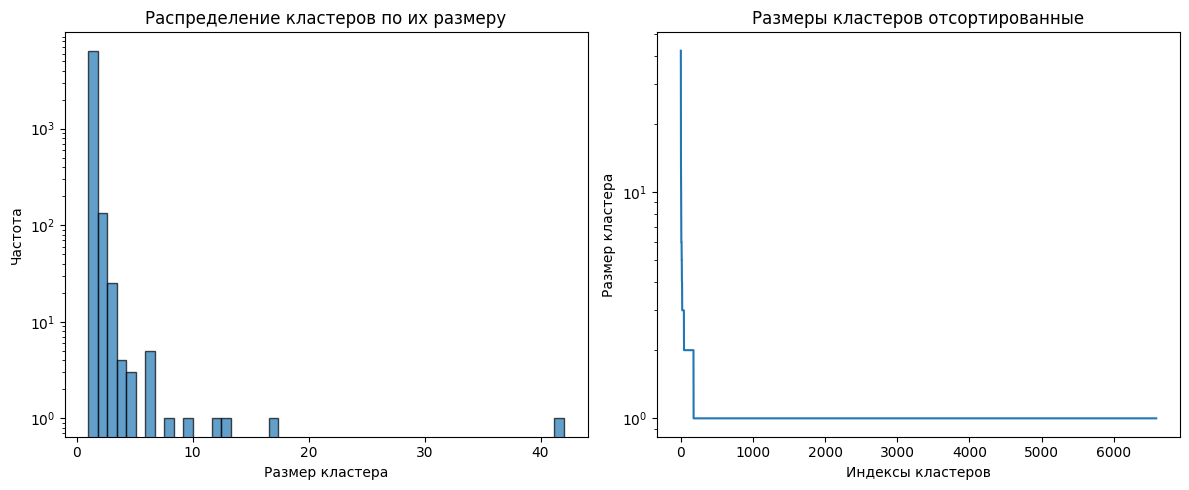

In [31]:

cluster_sizes = df['cluster'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(cluster_sizes.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Размер кластера')
plt.ylabel('Частота')
plt.title('Распределение кластеров по их размеру')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(range(len(cluster_sizes)), cluster_sizes.values)
plt.xlabel('Индексы кластеров')
plt.ylabel('Размер кластера')
plt.title('Размеры кластеров отсортированные')
plt.yscale('log')

plt.tight_layout()
plt.show()